In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')

In [4]:
tesla_ds = pd.read_csv('/content/TESLA.csv')

In [5]:
tesla_ds.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,6/29/10,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,1,6/30/10,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2,7/1/10,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,3,7/2/10,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,4,7/6/10,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [6]:
tesla_ds.set_index('Date', inplace = True)

In [7]:
tesla_ds.index = pd.to_datetime(tesla_ds.index, format='%m/%d/%y')

In [8]:
tesla_ds.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-06-29,0,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,2,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,3,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,4,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [9]:
tesla_ds = tesla_ds.drop('Unnamed: 0', axis=1)

In [10]:
tesla_ds.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


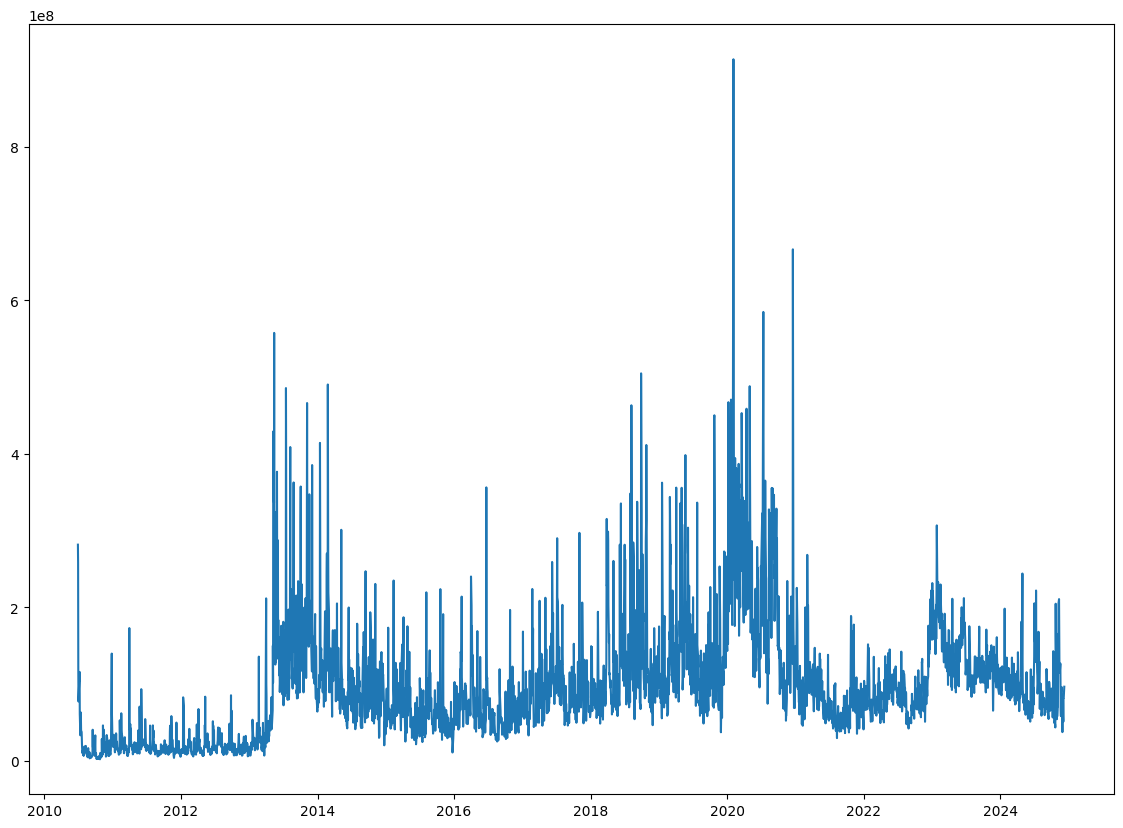

In [11]:
plt.figure(figsize=(14, 10))
plt.plot(tesla_ds['Volume'])

<Axes: xlabel='Date'>

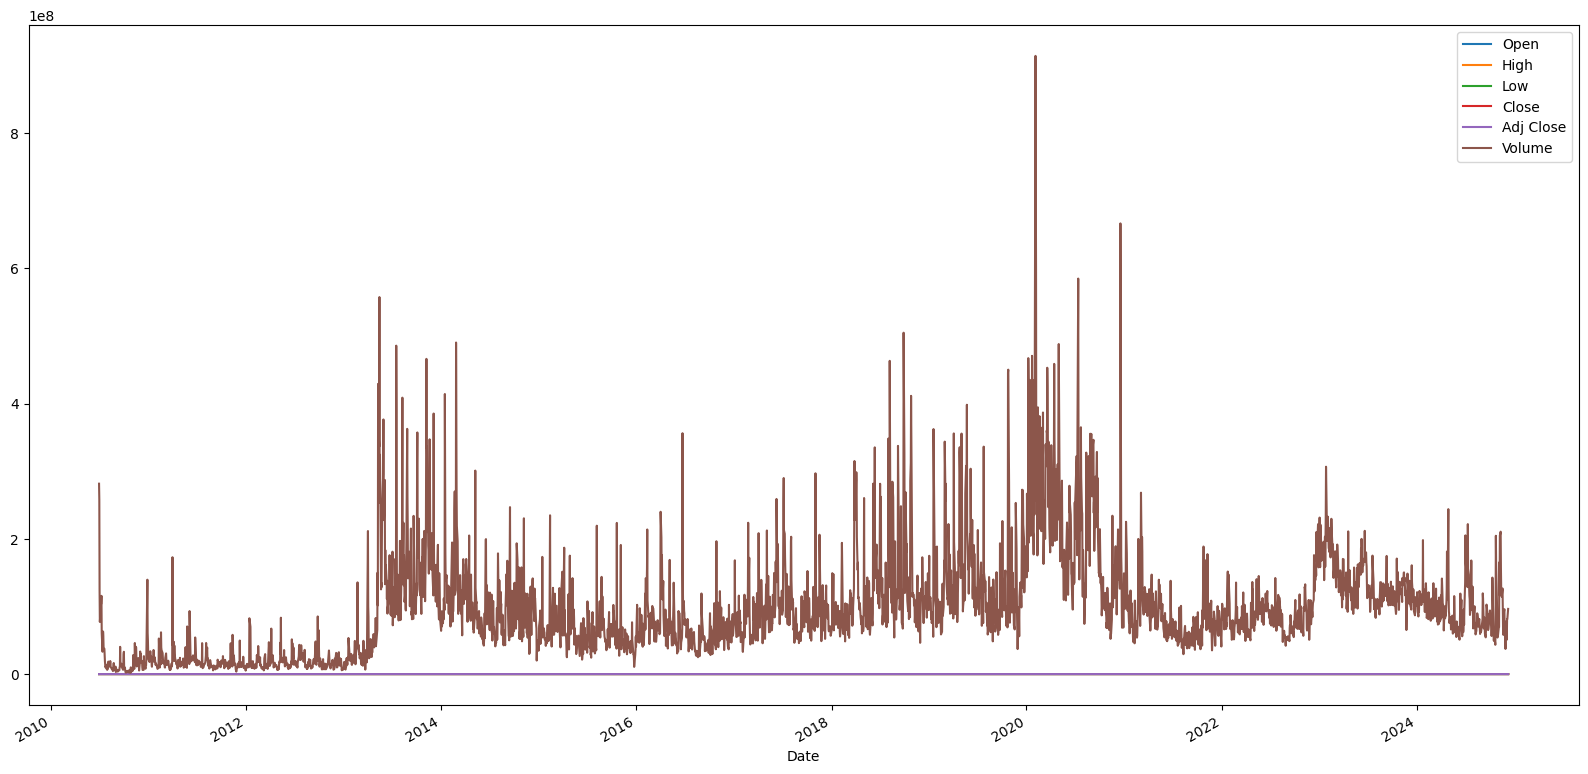

In [12]:
tesla_ds.plot(figsize=(20,10))

Text(0.5, 1.0, 'Tesla Stock at times..')

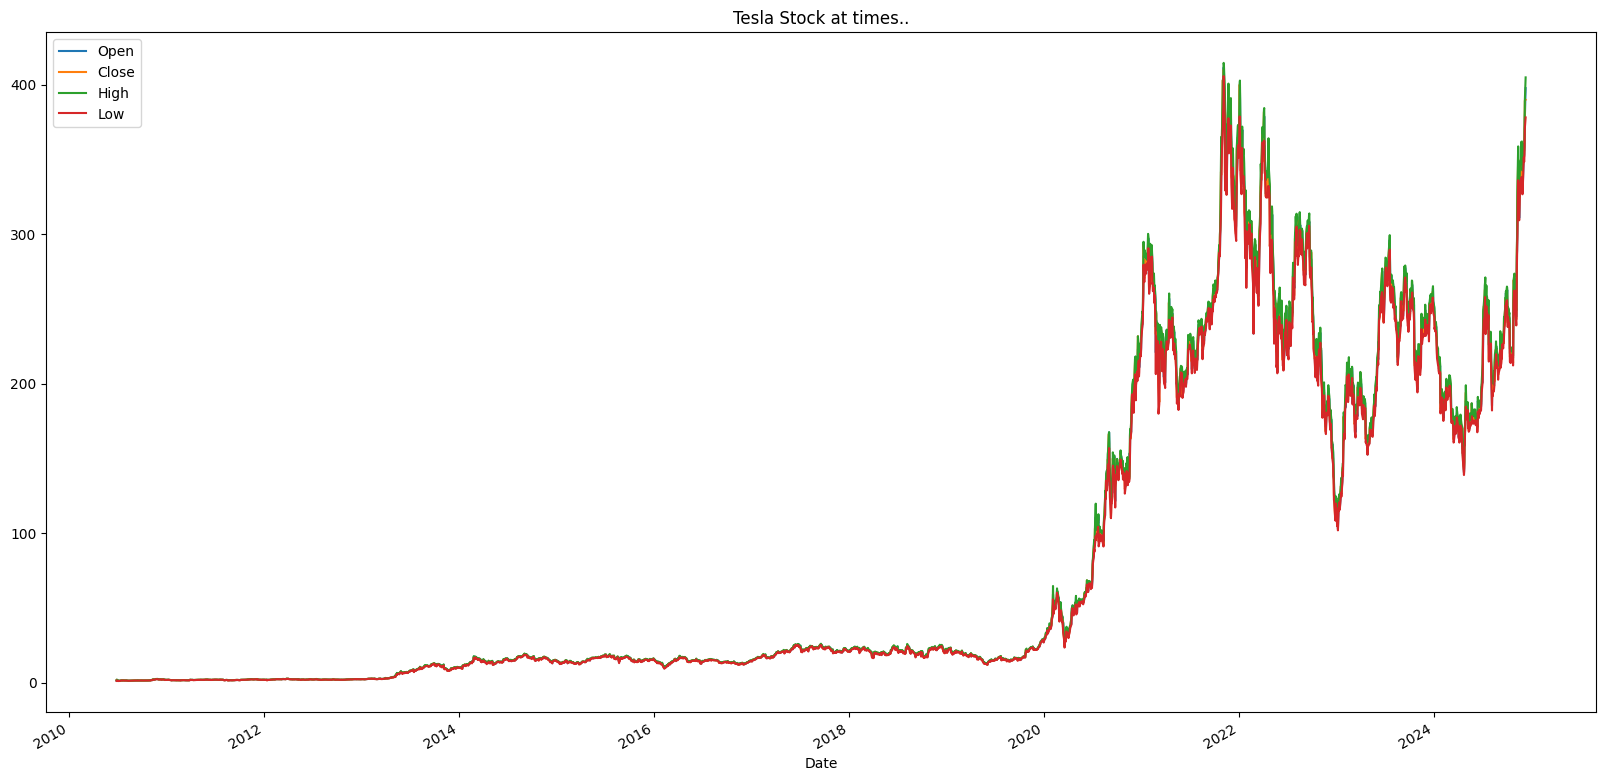

In [13]:
tesla_ds[['Open', 'Close', 'High', 'Low']].plot(figsize=(20,10))
plt.title('Tesla Stock at times..')

Text(0, 0.5, 'Stock Action')

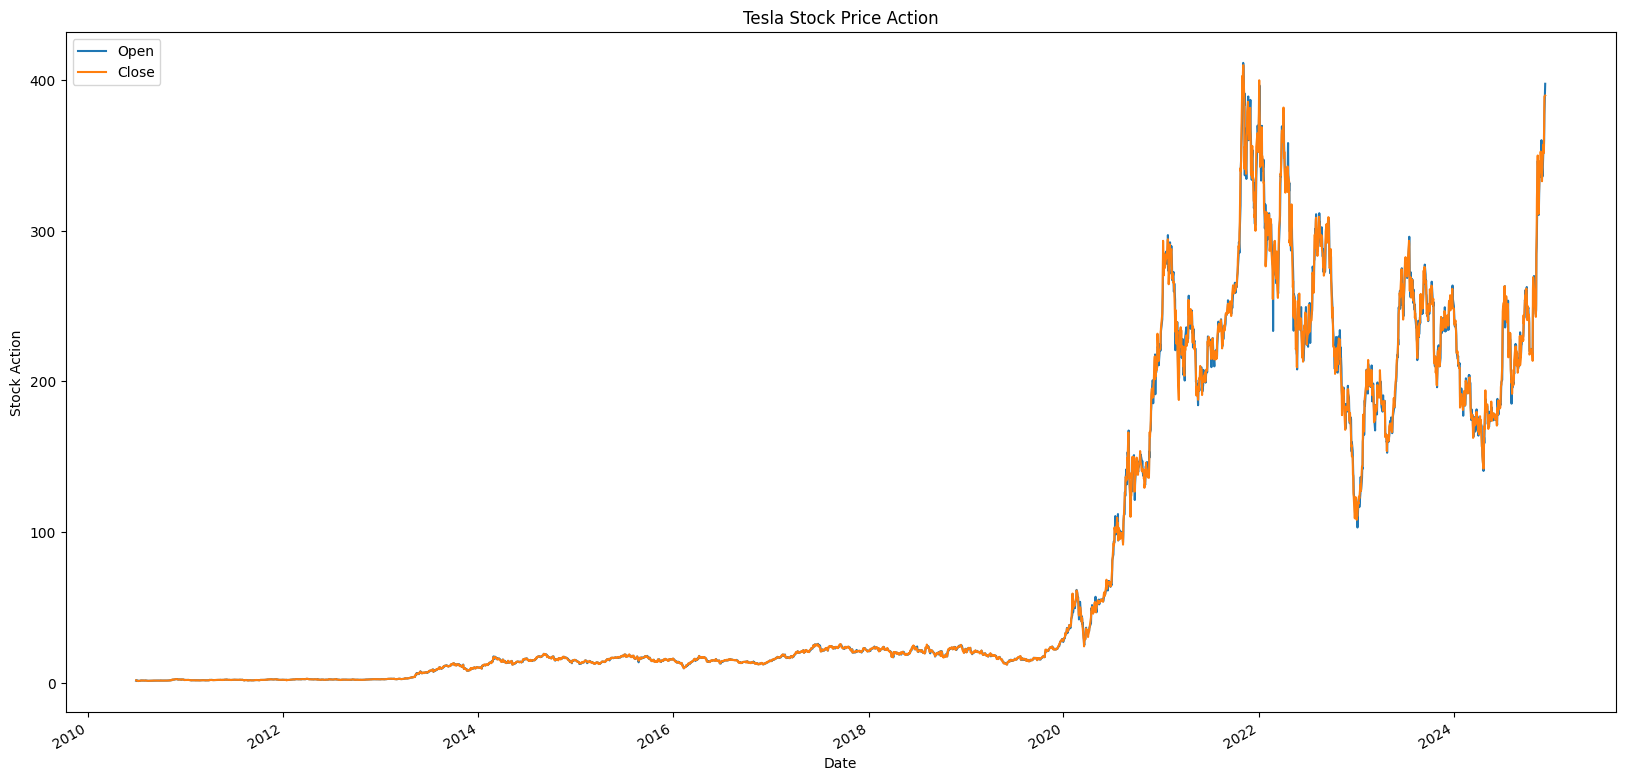

In [14]:
tesla_ds[['Open', 'Close']].plot(figsize=(20,10),alpha=1)
plt.title('Tesla Stock Price Action')
plt.xlabel('Date')
plt.ylabel('Stock Action')

Text(0, 0.5, 'Stock Action')

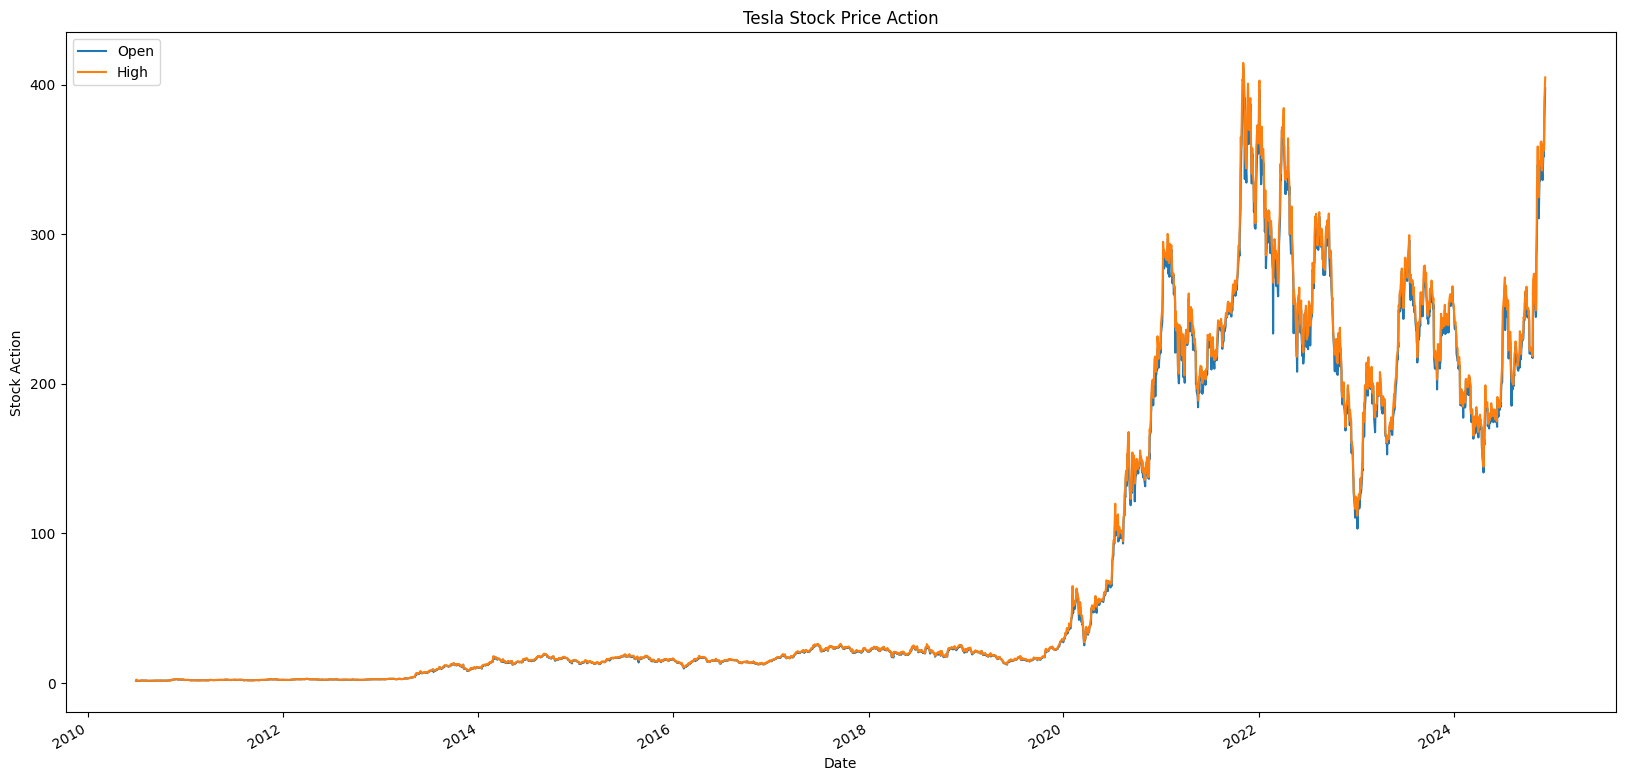

In [15]:
tesla_ds[['Open', 'High']].plot(figsize=(20,10),alpha=1)
plt.title('Tesla Stock Price Action')
plt.xlabel('Date')
plt.ylabel('Stock Action')

Text(0, 0.5, 'Stock Action')

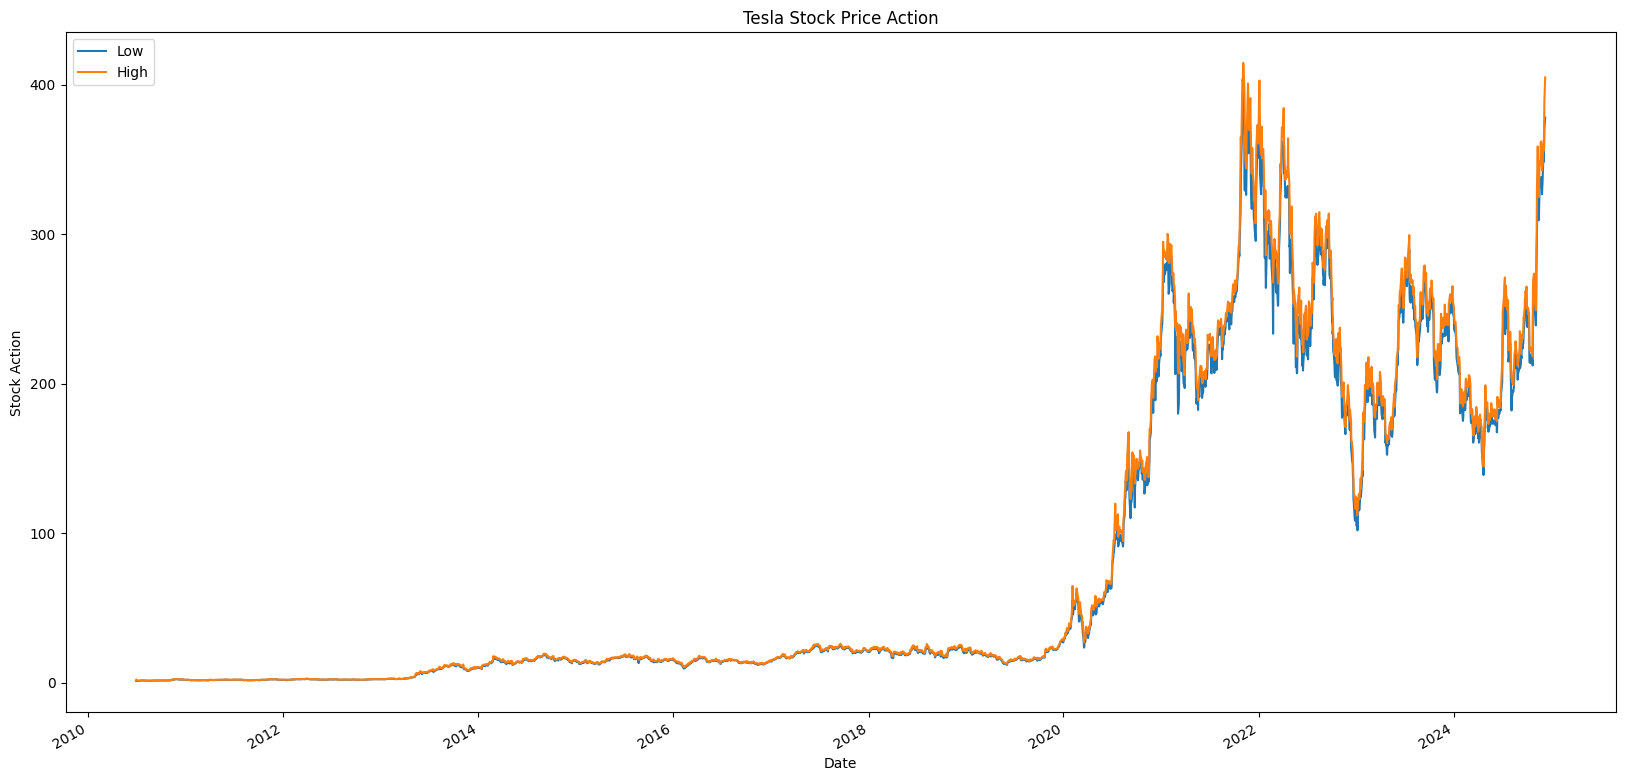

In [16]:
tesla_ds[['Low', 'High']].plot(figsize=(20,10),alpha=1)
plt.title('Tesla Stock Price Action')
plt.xlabel('Date')
plt.ylabel('Stock Action')

Text(0, 0.5, 'Stock Action')

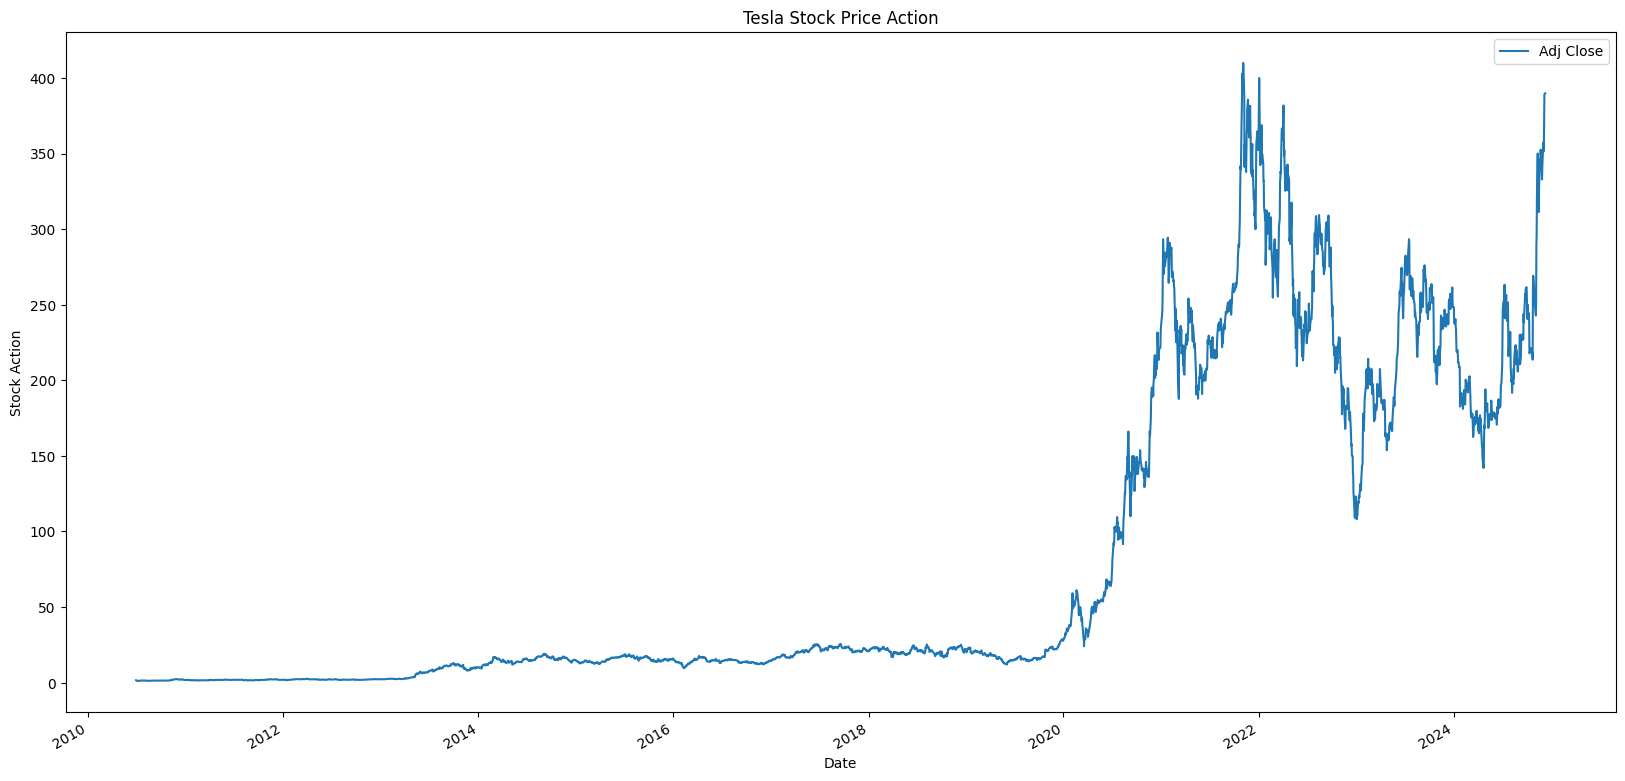

In [17]:
tesla_ds[['Adj Close']].plot(figsize=(20,10),alpha=1)
plt.title('Tesla Stock Price Action')
plt.xlabel('Date')
plt.ylabel('Stock Action')

In [18]:
scaler = StandardScaler()

tesla_ds['Close'] = scaler.fit_transform(tesla_ds[['Close']])

In [19]:
seq_length = 30
data = []

for i in range(len(tesla_ds) - seq_length):
  data.append(tesla_ds.Close[i:i+seq_length])

data = np.array(data)

In [20]:
train_size = int(0.8 * len(data))

x_train = torch.from_numpy(data[:train_size, :-1]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size, :-1]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size, -1:]).type(torch.Tensor).to(device)

In [21]:
class model(nn.Module):

  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(model, self).__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])

    return out




In [22]:
model_lstm = model(input_dim = 29, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [23]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

In [24]:
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

In [25]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model_lstm(x_train)

  loss = criterion(y_train_pred, y_train)

  if i % 10 ==0:
    print(i, loss.item())


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

0 0.5837609171867371
10 0.5099430680274963
20 0.41649875044822693
30 0.30220627784729004
40 0.18067392706871033
50 0.0826585441827774
60 0.037885285913944244
70 0.03259114548563957
80 0.03272898495197296
90 0.029777364805340767
100 0.027629192918539047
110 0.026039380580186844
120 0.024141298606991768
130 0.022196773439645767
140 0.02027108147740364
150 0.01843578740954399
160 0.0167386494576931
170 0.015150089748203754
180 0.013643043115735054
190 0.012234092690050602


In [26]:
model_lstm.eval()

model(
  (lstm): LSTM(29, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [27]:
sample_to_predict = torch.from_numpy(data[train_size:, :-1]).float()
sample_to_predict = sample_to_predict.unsqueeze(1).to(device)

y_test_pred = model_lstm(sample_to_predict)

In [28]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [29]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])

In [30]:
print(f"Train RMSE: {train_rmse}")

Train RMSE: 11.076932907104492


In [31]:
x_test_tensor = torch.from_numpy(data[train_size:, :-1]).float().to(device)
if len(x_test_tensor.shape) == 2:
    x_test_tensor = x_test_tensor.unsqueeze(1)

with torch.no_grad():
    y_test_pred_tensor = model_lstm(x_test_tensor)

y_test_pred = scaler.inverse_transform(y_test_pred_tensor.cpu().numpy())
y_test_actual = scaler.inverse_transform(data[train_size:, -1:])

test_rmse = root_mean_squared_error(y_test_actual, y_test_pred)

print(f"Test RMSE: {test_rmse}")

Test RMSE: 26.610468197963726


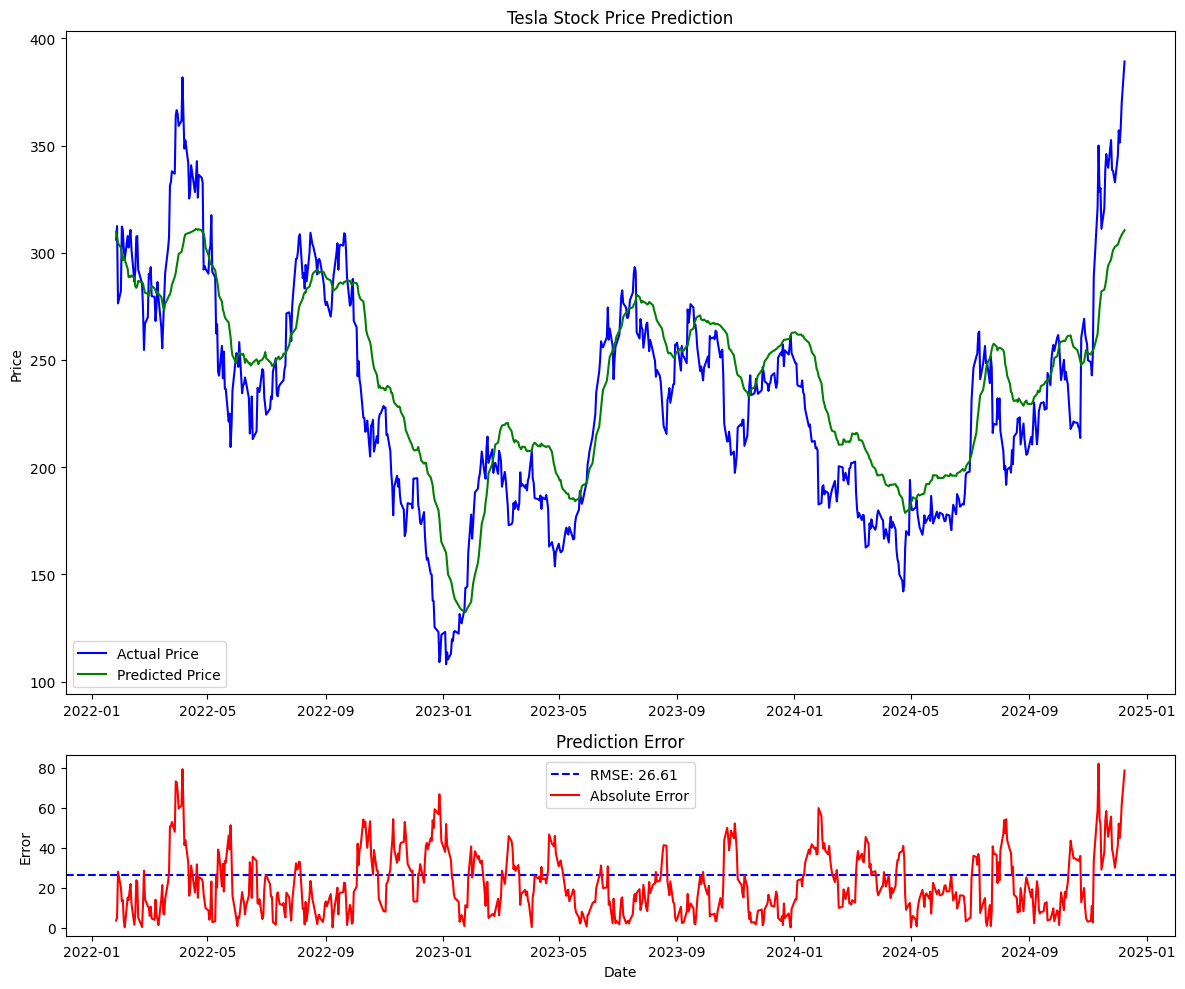

In [32]:

y_test_pred_plot = y_test_pred.flatten()
y_test_actual_plot = y_test_actual.flatten()

plot_dates = tesla_ds.index[-len(y_test_pred_plot):]

fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(plot_dates, y_test_actual_plot, color='blue', label='Actual Price')
ax1.plot(plot_dates, y_test_pred_plot, color='green', label='Predicted Price')
ax1.legend()
ax1.set_title("Tesla Stock Price Prediction")
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label=f"RMSE: {test_rmse:.2f}")
ax2.plot(plot_dates, abs(y_test_actual_plot - y_test_pred_plot), 'r', label='Absolute Error')
ax2.legend()
ax2.set_title('Prediction Error')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error')

plt.tight_layout()
plt.show()

In [64]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 36.2 MB/s eta 0:00:00


In [65]:
import optuna

In [75]:

x_train = torch.from_numpy(data[:train_size, :-1]).float().to(device)
y_train = torch.from_numpy(data[:train_size, -1:]).float().to(device) # Note the -1: to keep it 2D
x_test = torch.from_numpy(data[train_size:, :-1]).float().to(device)
y_test = torch.from_numpy(data[train_size:, -1:]).float().to(device)

if x_train.dim() == 2:
    x_train = x_train.unsqueeze(1)
if x_test.dim() == 2:
    x_test = x_test.unsqueeze(1)

print(f"Data reset successful. X shape: {x_train.shape}, Y shape: {y_train.shape}")

Data reset successful. X shape: torch.Size([2885, 1, 29]), Y shape: torch.Size([2885, 1])


In [78]:

from sklearn.metrics import root_mean_squared_error


def objective(trial):

    h_dim = trial.suggest_int("hidden_dim", 16, 128)
    n_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    model_lstm = model(input_dim=x_train.shape[-1],
                       hidden_dim=h_dim,
                       num_layers=n_layers,
                       output_dim=1).to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=lr)

    model_lstm.train()
    for epoch in range(50):
        y_train_pred = model_lstm(x_train)
        loss = criterion(y_train_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model_lstm.eval()
    with torch.no_grad():
        y_test_pred = model_lstm(x_test)

        y_pred_np = scaler.inverse_transform(y_test_pred.cpu().numpy())
        y_true_np = scaler.inverse_transform(y_test.cpu().numpy())

        val_rmse = root_mean_squared_error(y_true_np, y_pred_np)

    return val_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Best Score: {study.best_value}")
print(f"Best Params: {study.best_params}")

[I 2026-02-01 09:30:45,498] A new study created in memory with name: no-name-69fc0a49-81e0-40d1-b60a-4ce7c9da576b
[I 2026-02-01 09:30:46,082] Trial 0 finished with value: 51.94563674926758 and parameters: {'hidden_dim': 93, 'num_layers': 3, 'lr': 0.0011726387761362828}. Best is trial 0 with value: 51.94563674926758.
[I 2026-02-01 09:30:46,365] Trial 1 finished with value: 155.04258728027344 and parameters: {'hidden_dim': 19, 'num_layers': 3, 'lr': 0.0007839135235903643}. Best is trial 0 with value: 51.94563674926758.
[I 2026-02-01 09:30:46,537] Trial 2 finished with value: 32.20856857299805 and parameters: {'hidden_dim': 65, 'num_layers': 1, 'lr': 0.0019583330425862033}. Best is trial 2 with value: 32.20856857299805.
[I 2026-02-01 09:30:46,829] Trial 3 finished with value: 40.010276794433594 and parameters: {'hidden_dim': 119, 'num_layers': 1, 'lr': 0.0005991615316580881}. Best is trial 2 with value: 32.20856857299805.
[I 2026-02-01 09:30:47,140] Trial 4 finished with value: 30.4765357

Best Score: 14.9081392288208
Best Params: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.009929035267532511}


In [79]:
BEST_HIDDEN = 128
BEST_LAYERS = 3
BEST_LR = 0.009929035267532511

In [80]:

x_train_final = torch.from_numpy(data[:train_size, :-1]).float().to(device)
y_train_final = torch.from_numpy(data[:train_size, -1:]).float().to(device)
x_test_final = torch.from_numpy(data[train_size:, :-1]).float().to(device)
y_test_final = torch.from_numpy(data[train_size:, -1:]).float().to(device)

if x_train_final.dim() == 2:
    x_train_final = x_train_final.unsqueeze(1)
if x_test_final.dim() == 2:
    x_test_final = x_test_final.unsqueeze(1)

final_model = model(input_dim=x_train_final.shape[-1],
                    hidden_dim=BEST_HIDDEN,
                    num_layers=BEST_LAYERS,
                    output_dim=1).to(device)

criterion = torch.nn.HuberLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=BEST_LR)

In [81]:
num_epochs = 300
history = []

print("Starting Final Training...")
for epoch in range(num_epochs):
    final_model.train()

    # Forward
    preds = final_model(x_train_final)
    loss = criterion(preds, y_train_final)

    # Backward
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
    optimizer.step()

    history.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

print("Final Training Complete.")

Starting Final Training...
Epoch 0 | Loss: 0.294569
Epoch 50 | Loss: 0.002629
Epoch 100 | Loss: 0.001077
Epoch 150 | Loss: 0.000945
Epoch 200 | Loss: 0.000627
Epoch 250 | Loss: 0.000748
Final Training Complete.


In [82]:
final_model.eval()
with torch.no_grad():

    test_preds_tensor = final_model(x_test_final)

    test_preds = scaler.inverse_transform(test_preds_tensor.cpu().numpy())
    test_actuals = scaler.inverse_transform(y_test_final.cpu().numpy())

final_rmse = root_mean_squared_error(test_actuals, test_preds)
print(f"Final Test RMSE: ${final_rmse:.2f}")


Final Test RMSE: $10.09


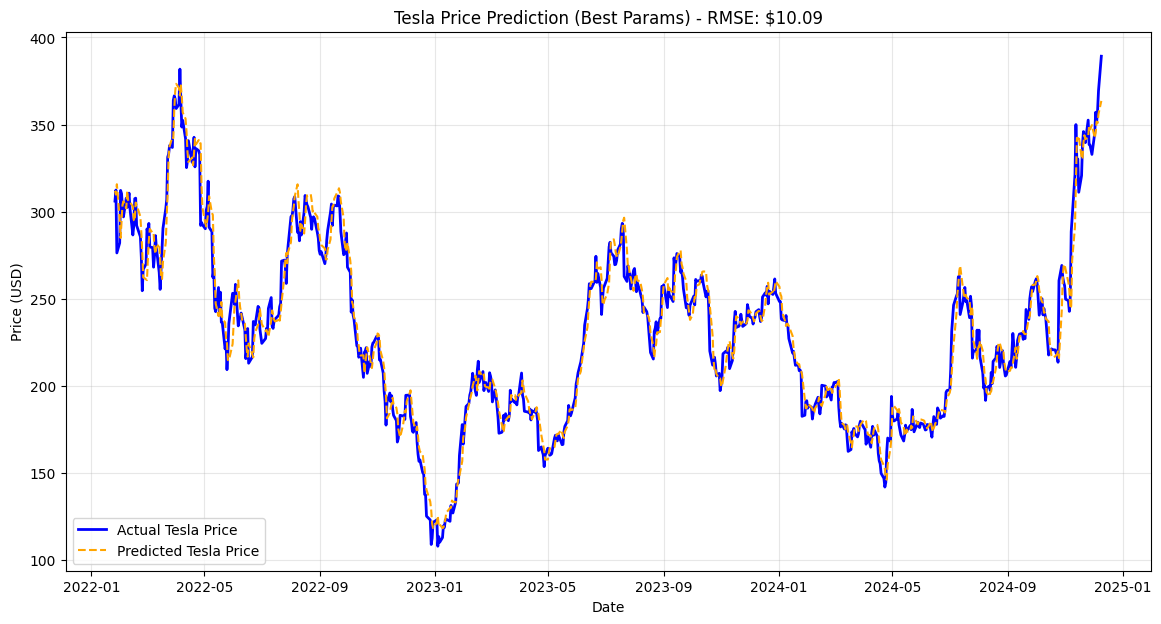

In [83]:
plt.figure(figsize=(14, 7))
plt.plot(tesla_ds.index[-len(test_actuals):], test_actuals, label='Actual Tesla Price', color='blue', lw=2)
plt.plot(tesla_ds.index[-len(test_preds):], test_preds, label='Predicted Tesla Price', color='orange', linestyle='--')
plt.title(f"Tesla Price Prediction (Best Params) - RMSE: ${final_rmse:.2f}")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()